### 1. IMPORTAÇÃO DE BIBLIOTECAS

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow com instalação automática se necessário
try:
    import tensorflow as tf
    print("TensorFlow já instalado. Versão:", tf.__version__)
except ImportError:
    print("TensorFlow não encontrado. Instalando...")
    !pip install -q tensorflow
    import tensorflow as tf
    print("TensorFlow versão:", tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from google.colab import drive

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

TensorFlow já instalado. Versão: 2.19.0


### 2. DEFINIÇÕES

In [ ]:
dataset_drive_path = "/content/drive/MyDrive/MeuTCC2/dataset/realwaste-main/RealWaste/"
dataset_drive_aug = "/content/drive/MyDrive/MeuTCC2/dataset/realwaste-main/RealWaste/"
dataset_local_path = "/content/RealWaste_local"
model_path = "/content/drive/MyDrive/MeuTCC2/modelo_realwaste.keras"
tflite_model_path = "/content/drive/MyDrive/MeuTCC2/realwaste_mobilenetv2_quant.tflite"

### 3. MONTA O DRIVE

In [ ]:
# Se o dataset local ainda não existe, copia do Drive
if not os.path.exists(dataset_local_path):
    # Montar o Drive, se ainda não estiver
    if not os.path.exists("/content/drive/MyDrive"):
        drive.mount('/content/drive')

    print("Copiando dataset do Drive para o armazenamento local...")
    os.system(f'rsync -av --progress "{dataset_drive_path}" "{dataset_local_path}"')
    print("Cópia concluída!")
else:
    print("Dataset já copiado localmente.")

Dataset já copiado localmente.


### 4. CRIA DATASETS

In [ ]:
img_size = (224, 224)
batch_size = 64 #alterado de 32 para 64

print(f"Dados para treino:")
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_local_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

print(f"\nDados para Validação")
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_local_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Dados para treino:
Found 8211 files belonging to 9 classes.
Using 6569 files for training.

Dados para Validação
Found 8211 files belonging to 9 classes.
Using 1642 files for validation.


### 5. CARREGA MODELO BASE

In [ ]:
# Carregar MobileNetV2 como base
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    alpha=1,            ### ATUALIZADO PARA 1 NO ENSAIO 4
    include_top=False,    # remove a camada de classificação final
    weights='imagenet'    # pesos pré-treinados
)

# Descongela modelo para fine-tuning
base_model.trainable = True

# Congela todas menos as últimas 80 camadas
for layer in base_model.layers[:-80]: #aumentado de 50 para 80 no ensaio4
    layer.trainable = False

print("MobileNetV2 carregado como base")

MobileNetV2 carregado como base


### 6. ADICIONA CAMADAS FINAIS PARA CLASSIFICAÇÃO

In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(train_ds.class_names), activation='softmax')
])

#optimizer = RMSprop(learning_rate=1e-4, rho=0.9, momentum=0.0)
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)
#optimizer=Adam(learning_rate=1e-4)

# Compilar modelo
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 2,232,841 (8.52 MB)

 Non-trainable params: 190,272 (743.25 KB)

###6.1 weighted loss

In [ ]:
# Obter todas as labels do dataset
y_train = np.concatenate([y.numpy() for x, y in train_ds], axis=0)

# Obter classes
classes = np.arange(len(train_ds.class_names))  # 0,1,2,...,n_classes-1

# Calcular pesos
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

data = {
    'Classe': train_ds.class_names,
    'Peso': [class_weight_dict[i] for i in range(len(train_ds.class_names))]
}

df = pd.DataFrame(data)
print(df)

                Classe      Peso
0            Cardboard  1.002595
1        Food Organics  0.986336
2                Glass  1.033837
3                Metal  0.997116
4  Miscellaneous Trash  1.006743
5                Paper  0.993046
6              Plastic  0.962914
7        Textile Trash  1.012329
8           Vegetation  1.008134


### 7. TREINAMENTO

In [ ]:
# Configurar EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',      # métrica a ser monitorada
    patience=10,              # número de epochs sem melhora antes de parar AUMENTADO DE 5 PARA 15 NO ENSAIO 4
    restore_best_weights=True  # restaura pesos do melhor epoch
)

# Configura redução automática de learning-rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # métrica a ser monitorada
    factor=0.5,           # reduz a LR pela metade quando estagnar
    patience=3,           # espera 3 epochs sem melhora antes de reduzir
    min_lr=1e-6,          # LR mínima permitida
    verbose=1             # imprime mensagens quando reduzir
)

base_model.trainable = False
model.fit(train_ds, validation_data=val_ds, epochs=5)

# Continua o treino normalmente
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

print(f"Treinamento concluído!")

Epoch 1/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 30s 204ms/step - accuracy: 0.1567 - loss: 2.4822 - val_accuracy: 0.4184 - val_loss: 1.7059
Epoch 2/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.3683 - loss: 1.7220 - val_accuracy: 0.4878 - val_loss: 1.4529
Epoch 3/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4395 - loss: 1.5485 - val_accuracy: 0.5158 - val_loss: 1.3472
Epoch 4/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4819 - loss: 1.4338 - val_accuracy: 0.5420 - val_loss: 1.2851
Epoch 5/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.5105 - loss: 1.3524 - val_accuracy: 0.5560 - val_loss: 1.2307
Epoch 1/150
103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.5390 - loss: 1.2963 - val_accuracy: 0.5603 - val_loss: 1.1909 - learning_rate: 1.0000e-04
Epoch 2/150
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.5479 - loss: 1.2406 - val_accuracy: 0.5907 - val_loss: 1.1527 - learning_rate: 1.0000e-04
Epoch 3/150
103/103 ━━━━━━━━━━━━━━━━━━━━

### 7.1 HISTÓRICO DO TREINAMENTO

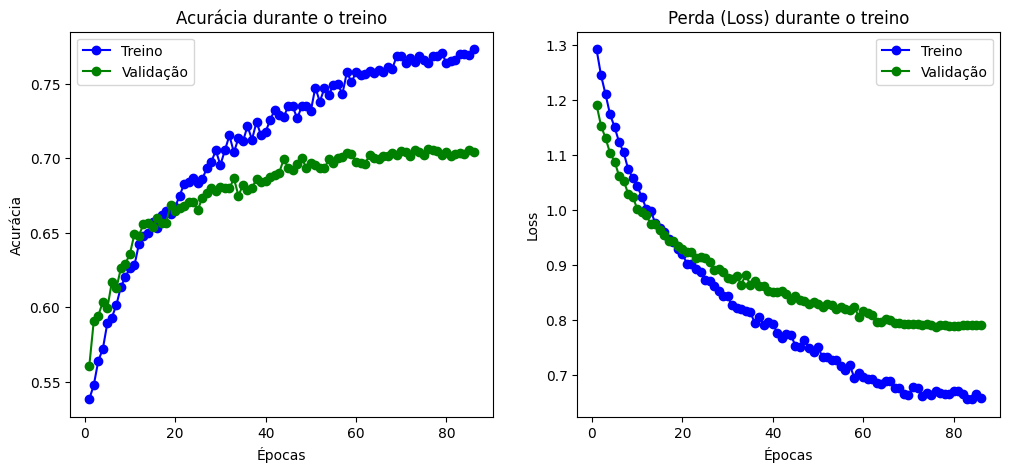

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Gráfico 1: Acurácia
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo-', label='Treino')
plt.plot(epochs, val_acc, 'go-', label='Validação')
plt.title('Acurácia durante o treino')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico 2: Perda
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo-', label='Treino')
plt.plot(epochs, val_loss, 'go-', label='Validação')
plt.title('Perda (Loss) durante o treino')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 7.2 SALVAR O MODELO FLOAT32

In [ ]:
model.save(model_path)
print(f"Modelo salvo em: {model_path}")

Modelo salvo em: /content/drive/MyDrive/MeuTCC2/modelo_realwaste.keras


### 8. QUANTIZAÇÃO PARA INT8

In [ ]:
# Converter para TFLite com quantização
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Dataset para calibrar quantização
def representative_data_gen():
    for images, _ in train_ds.take(100):
        yield [tf.cast(images, tf.float32)]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model = converter.convert()

# Salvar modelo quantizado
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"Modelo TFLite quantizado salvo em: {tflite_model_path}")

Saved artifact at '/tmp/tmphj4onqvi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_314')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  132759154083024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132759154081872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132759154083600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132759154082640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132759154083408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132759154082256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132759153393296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132759153387728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132759153393488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132759153388304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1327591533

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Modelo TFLite quantizado salvo em: /content/drive/MyDrive/MeuTCC2/realwaste_mobilenetv2_quant.tflite


### MÉTRICAS DO MODELO

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


<Figure size 1000x1000 with 0 Axes>

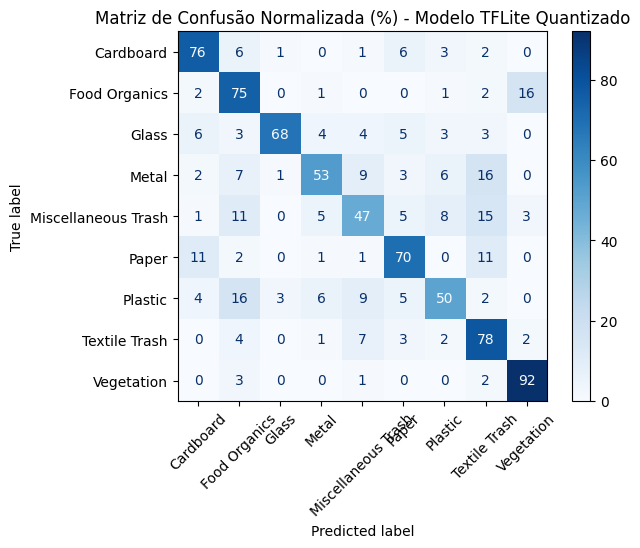

In [ ]:
# Carregar TFLite
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Lista com nomes das classes
class_names = sorted([name for name in os.listdir(dataset_local_path) if os.path.isdir(os.path.join(dataset_local_path, name))])

# Arrays para guardar labels e previsões
y_true = []
y_pred = []
y_score = []

for images, labels in val_ds:
    for i in range(len(images)):
        img = images[i:i+1]
        label = labels[i].numpy()

        # Ajustar tipo de dado
        if input_details[0]['dtype'] == np.uint8:
            img = tf.cast(img, tf.uint8)
        else:
            img = tf.cast(img, tf.float32)

        interpreter.set_tensor(input_details[0]['index'], img)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])

        pred_class = output.argmax()

        y_true.append(label)
        y_pred.append(pred_class)
        y_score.append(output[0])  # <- guardar probabilidades para ROC

# Converter para arrays numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)  # shape: [n_samples, n_classes]

# Gerar matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Normalizar a matriz de confusão para porcentagens inteiras
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_normalized = cm_normalized.astype('int') # Converter para inteiros

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)

# Plot
plt.figure(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusão Normalizada (%) - Modelo TFLite Quantizado")

plt.show()

In [ ]:
# Métricas gerais
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (weighted): {precision:.2f}")
print(f"Recall (weighted): {recall:.2f}")
print(f"F1-score (weighted): {f1:.2f}")

# Relatório detalhado com nomes das classes
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Accuracy: 0.68
Precision (weighted): 0.69
Recall (weighted): 0.68
F1-score (weighted): 0.68

Classification Report:

                     precision    recall  f1-score   support

          Cardboard       0.73      0.77      0.75       182
      Food Organics       0.56      0.75      0.64       173
              Glass       0.92      0.68      0.78       204
              Metal       0.73      0.54      0.62       188
Miscellaneous Trash       0.58      0.48      0.53       190
              Paper       0.69      0.70      0.70       176
            Plastic       0.62      0.51      0.56       163
      Textile Trash       0.57      0.78      0.66       182
         Vegetation       0.81      0.92      0.86       184

           accuracy                           0.68      1642
          macro avg       0.69      0.68      0.68      1642
       weighted avg       0.69      0.68      0.68      1642



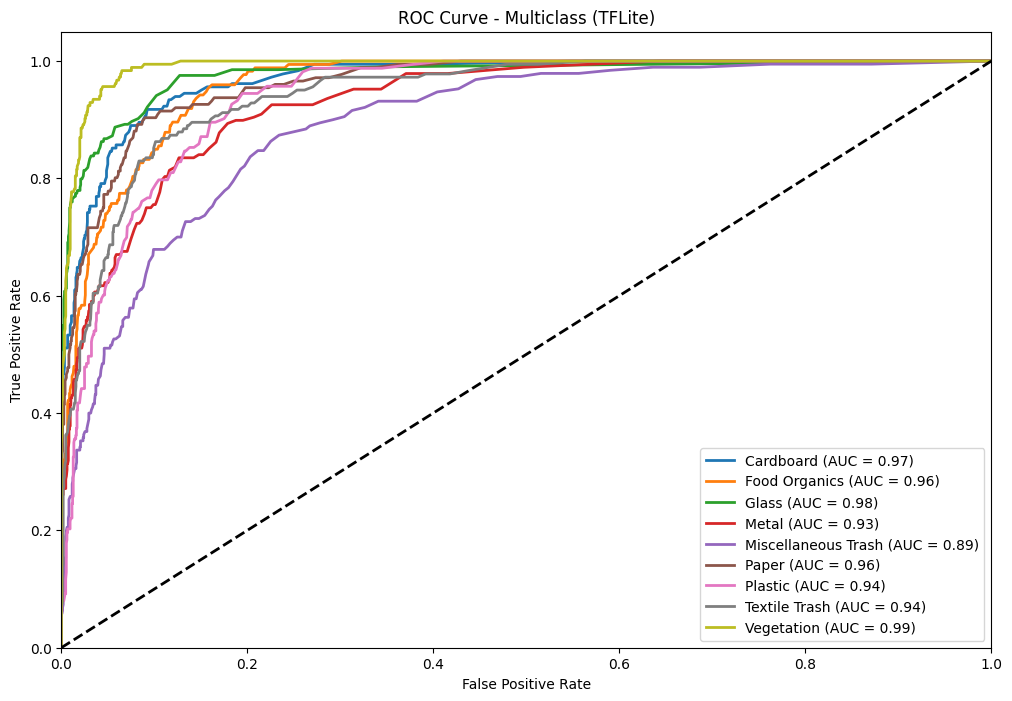

In [ ]:
# --- ROC Multiclasse ---

# Garantir que y_true está em formato numpy array
y_true = np.array(y_true)

# Classes (nomes) e número total
classes = class_names
n_classes = len(classes)

# Binarizar y_true com base nos nomes das classes
# Atenção: as labels em y_true devem ser índices numéricos, não strings
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Plotar ROC para cada classe
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multiclass (TFLite)')
plt.legend(loc="lower right")
plt.show()